# Práctica 2: Color

## Instalación

Para esta guía práctica se utilizó Python 3, las bibliotecas Scipy y Numpy para operaciones básicas con matrices y carga de archivos de imágenes, MatplotLib para graficar los resultados, y Jupyter para generar este documento.

En Ubuntu, se puede instalar Python y el manejador de paquetes *pip* con `apt-get`:

```
sudo apt-get install python3 python3-pip
```

Luego se pueden instalar las dependencias con pip, usando el archivo de dependencias incluido:

```
sudo -H pip install -r requirements.txt
```

Finalmente, se puede arrancar una instancia de Jupyter y abrir el archivo .ipynb adjunto:

```
$ jupyter notebook
```

## Inicialización

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
%matplotlib inline

In [2]:
L = 256

In [3]:
X = np.arange(L)

# Algunas experimentaciones con RGB y HSI

## Histograma de cada canal RGB

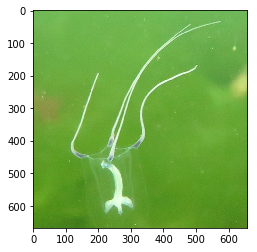

In [4]:
img = imread('img/1901xx.jpg')
plt.imshow(img)

Se importan funciones de la práctica 1 para generar el histograma de un canal:

In [5]:
def freq(img):
    '''Calcula la frecuencia de cada nivel del gris de la imagen'''
    freq = np.zeros(L)
    for x in np.nditer(img):
        freq[x] += 1
    return freq

def histogram(img):
    '''Devuelve el histograma normalizado de la imagen'''
    hist = freq(img)
    # Divide todos los valores por el tamaño de la imagen
    # para obtener la frecuencia relativa
    w, h = img.shape
    return hist / (w * h)

Se extraen los canales RGB (rojo, verde y azul) en 3 matrices y se grafican sus histogramas

In [6]:
red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]

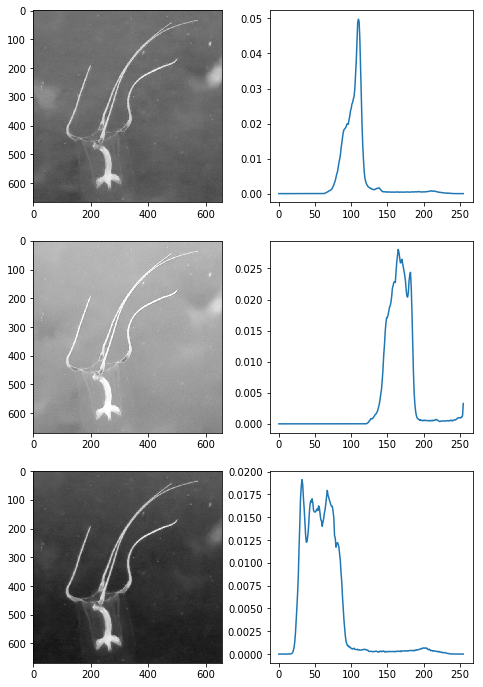

In [7]:
fig, ((r, rh), (g, gh), (b, bh)) = plt.subplots(3, 2)
fig.set_figwidth(8)
fig.set_figheight(12)

r.imshow(red, cmap=plt.cm.gray, vmin=0, vmax=L-1)
rh.plot(X, histogram(red))
g.imshow(green, cmap=plt.cm.gray, vmin=0, vmax=L-1)
gh.plot(X, histogram(green))
b.imshow(blue, cmap=plt.cm.gray, vmin=0, vmax=L-1)
bh.plot(X, histogram(blue))

## Ecualización de cada canal

In [8]:
def histogram_cdf(img):
    '''Calcula la suma acumulada del histograma'''
    hist = np.cumsum(freq(img))
    w, h = img.shape
    return hist / (w * h)

def histeq(img):
    '''Aplica ecualización de histograma estándar sobre una imagen'''
    
    # Calcula el histograma de la imagen original,
    # y su función de distribución acumulada.
    h = histogram(img)
    h_acum = histogram_cdf(img)
    
    # Busca el minimo en la acumulada
    s_min = h_acum.min()
    
    # Genera el nuevo histograma de distribución uniforme
    # [0, L-1] a partir de la acumulada original, y escalo
    # los valores para poder generar una nueva imagen con el
    # nuevo histograma.
    hist = np.floor(((h_acum - s_min) / (1 - s_min)) * (L - 1) + 0.5)
    t = np.vectorize(lambda x: hist[x], otypes=[np.uint8])

    return t(img)

Se ecualiza cada canal por separado:

In [9]:
red_eq = histeq(red)
green_eq = histeq(green)
blue_eq = histeq(blue)

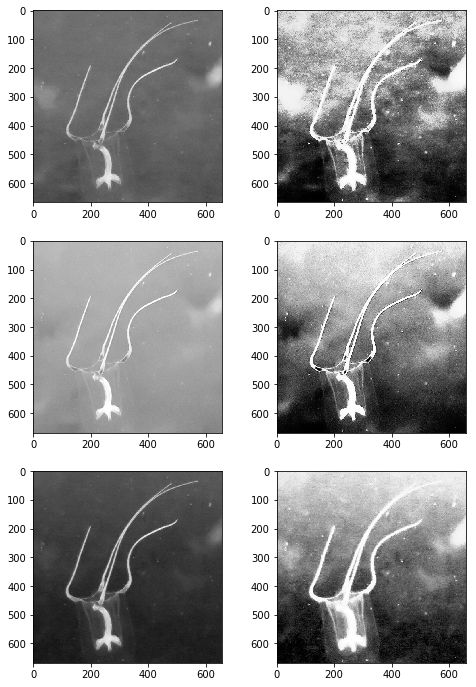

In [10]:
fig, ((r, req), (g, geq), (b, beq)) = plt.subplots(3, 2)
fig.set_figwidth(8)
fig.set_figheight(12)

r.imshow(red, cmap=plt.cm.gray, vmin=0, vmax=L-1)
req.imshow(red_eq, cmap=plt.cm.gray, vmin=0, vmax=L-1)

g.imshow(green, cmap=plt.cm.gray, vmin=0, vmax=L-1)
geq.imshow(green_eq, cmap=plt.cm.gray, vmin=0, vmax=L-1)

b.imshow(blue, cmap=plt.cm.gray, vmin=0, vmax=L-1)
beq.imshow(blue_eq, cmap=plt.cm.gray, vmin=0, vmax=L-1)

Se juntan los 3 canales en una sola imagen RGB de nuevo, para poder graficarla a color.

In [11]:
img_eq = np.dstack((red_eq, green_eq, blue_eq))

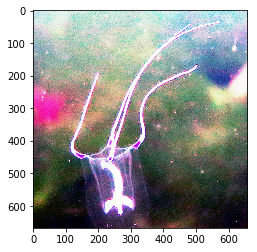

In [12]:
plt.imshow(img_eq, vmin=0, vmax=L-1)

Se puede apreciar que la ecualización deterioró bastante la tonalidad de la imagen.

## Conversión RGB a HSI

In [13]:
def img_to_norm_rgb(img):
    '''Toma una imagen a color y devuelve cada canal RGB normalizado a 0-1'''
    norm_img = img / L
    return norm_img[:,:,0], norm_img[:,:,1], norm_img[:,:,2]

In [14]:
def rgb_to_hsi(r, g, b):
    '''
    Conversión RGB a HSI
    
    Toma y retorna arreglos normalizados 0-1

    '''
    # Intensidad
    i = (r + g + b) / 3
    
    # Tono (hue) - al final normalizo el tono dividiendo por Pi
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt(np.power(r - g, 2) + (r - b) * (g - b))
    # h es una función partida...
    h = np.select([b <= g, b > g], [np.arccos(num / den),
                                    2*np.pi - np.arccos(num / den)]) / (2*np.pi)
    
    # Saturación
    s = 1 - (3 / (r + g + b)) * np.array([r, g, b]).min(axis=0)
    
    return h, s, i

In [15]:
# Normalizo los canales RGB a 0-1
r, g, b = img_to_norm_rgb(img)

# Convierto al espacio HSI
h, s, i = rgb_to_hsi(r, g, b)

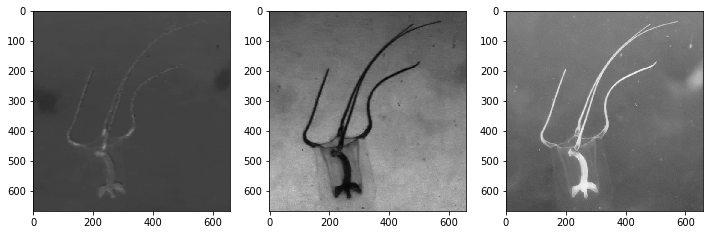

In [16]:
fig, (hfig, sfig, ifig) = plt.subplots(1, 3)
fig.set_figwidth(12)

hfig.imshow(h, cmap=plt.cm.gray, vmin=0, vmax=1)
sfig.imshow(s, cmap=plt.cm.gray, vmin=0, vmax=1)
ifig.imshow(i, cmap=plt.cm.gray, vmin=0, vmax=1)

## Ecualización de la intensidad, conversión de HSI a RGB

Teniendo la imagen separada en canales HSI, se puede trabajar sobre componentes de la imagen que están más asociados a cómo el ojo humano percibe los colores. Para aumentar el contraste, una opción es ecualizar el histograma del canal Intensidad.

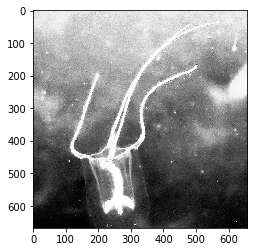

In [17]:
i_eq = histeq((i * L).astype(np.uint8))
plt.imshow(i_eq, cmap=plt.cm.gray, vmin=0, vmax=L-1)

Ahora para recomponer la imagen y mostrarla, se debe convertir el espacio HSI modificado al RGB de nuevo.

In [18]:
def hsi_to_rgb(h, s, i):
    '''
    Conversión HSI a RGB
    
    Toma y retorna arreglos normalizados 0-1

    '''
    # Escala el hue de 0-1 a 0-2pi, y se queda con el resto módulo 2pi
    h = (h * 2*np.pi) % (2*np.pi)
    
    # Usa h % 2/3pi para trabajar en cada parte del cilindro HSI
    hp = h % ((2/3) * np.pi)
    x = i * (1 + (s * np.cos(hp) / np.cos(np.pi/3 - hp)))
    y = i * (1 - s)
    z = 3*i - (x + y)
    
    # Función partida según en qué region del cilindro está el hue
    res = np.select([
        np.logical_and(h >= 0, h < (2/3)*np.pi),
        np.logical_and(h >= (2/3)*np.pi, h < (4/3)*np.pi),
        np.logical_and(h >= (4/3)*np.pi, h < 2*np.pi)
    ], [(x, z, y), (y, x, z), (z, y, x)])
        
    return res

In [19]:
def norm_rgb_to_img(norm_r, norm_g, norm_b):
    '''Devuelve una imagen RGB a partir de 3 matrices R, G, B normalizadas'''
    r = np.minimum(np.round(norm_r * L), L-1).astype(np.uint8)
    g = np.minimum(np.round(norm_g * L), L-1).astype(np.uint8)
    b = np.minimum(np.round(norm_b * L), L-1).astype(np.uint8)
    return np.dstack([r, g, b])

In [20]:
nr, ng, nb = hsi_to_rgb(h, s, i_eq / L)
new_img = norm_rgb_to_img(nr, ng, nb)

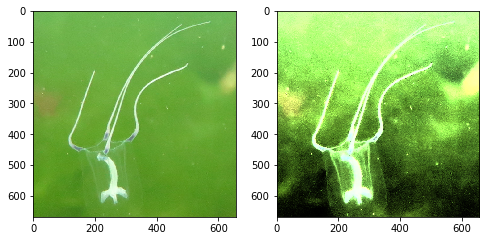

In [21]:
fig, (a, b) = plt.subplots(1, 2)
fig.set_figwidth(8)

a.imshow(img, vmin=0, vmax=L-1)
b.imshow(new_img, vmin=0, vmax=L-1)

Se puede observar que esta vez, el tono de la imagen y su saturación no se vieron afectados por la ecualización de la intensidad.

## Transformaciones puntuales sobre modelo HSI

De la misma manera en la que se ecualizó un canal del espacio HSI, se pueden aplicar transformaciones puntuales.

In [22]:
def transform_hsi(img, func):
    '''
    Transforma los canales HSI de una imagen usando +func+
    
    +func+ es una funcion que recibe los 3 canales HSI,
    y debe devolver una tupla con los canales modificados.
    
    '''
    norm_img = img / L
    r, g, b = norm_img[:,:,0], norm_img[:,:,1], norm_img[:,:,2]
    h, s, i = rgb_to_hsi(r, g, b)
    th, ts, ti = func(h, s, i)
    tr, tg, tb = hsi_to_rgb(th, ts, ti)
    return norm_rgb_to_img(tr, tg, tb)

In [23]:
def tr_log_intensity(img):
    return transform_hsi(img, lambda h, s, i: (h, s, np.log(i + 1)))

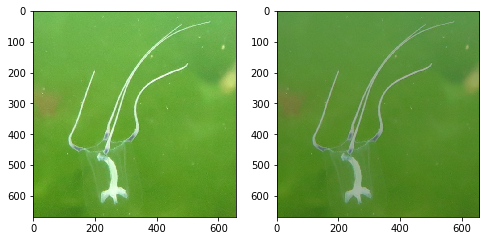

In [24]:
fig, (a, b) = plt.subplots(1, 2)
fig.set_figwidth(8)

a.imshow(img, vmin=0, vmax=L-1)
b.imshow(tr_log_intensity(img), vmin=0, vmax=L-1)

# Ejercicios práctica 2

Observación: Al convertir a HSI, nos quedan los valores H,S,I periódicos (de 0 a 1)

## 1a. Realce de saturación

In [25]:
def tr_mult_saturation(img, factor):
    return transform_hsi(img, lambda h, s, i: (h, np.clip(s * factor, 0, 1), i))

In [26]:
sat_15 = tr_mult_saturation(img, 1.5)
sat_05 = tr_mult_saturation(img, 0.5)
sat_025 = tr_mult_saturation(img, 0.25)

Text(0.5, 1.0, 'Imagen con saturación *0.25')

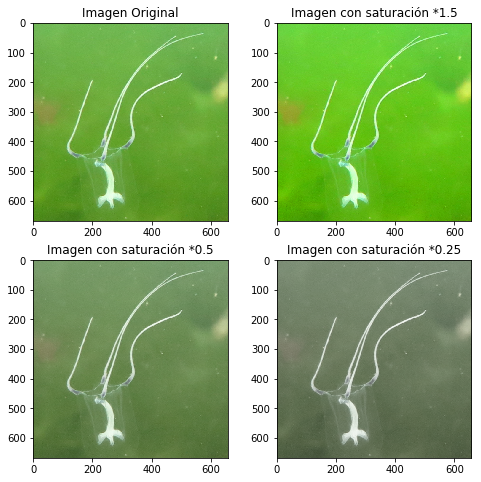

In [27]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)


a.set_title("Imagen Original")
a.imshow(img, vmin=0, vmax=L-1)

b.imshow(sat_15, vmin=0, vmax=L-1)
b.set_title("Imagen con saturación *1.5")

c.imshow(sat_05, vmin=0, vmax=L-1)
c.set_title("Imagen con saturación *0.5")

d.imshow(sat_025, vmin=0, vmax=L-1)
d.set_title("Imagen con saturación *0.25")

En la figura se puede observar que al multiplicar por un $c > 1$ la intensidad aumenta, y con un $c < 1$ baja, a tal punto que si $c = 0$, la imagen termina perdiendo todo valor de color.

## 1b. Aplicando transformaciones a la saturación

### Transformaciones lineales

In [28]:
def transform_hsi(img, func):
    '''
    Transforma los canales HSI de una imagen usando +func+
    
    +func+ es una funcion que recibe los 3 canales HSI,
    y debe devolver una tupla con los canales modificados.
    
    '''
    norm_img = img / L
    r, g, b = norm_img[:,:,0], norm_img[:,:,1], norm_img[:,:,2]
    h, s, i = rgb_to_hsi(r, g, b)
    th, ts, ti = func(h, s, i)
    tr, tg, tb = hsi_to_rgb(th, ts, ti)
    return norm_rgb_to_img(tr, tg, tb)

In [29]:
def tr_linear_transformation_saturation(img, factor_a, factor_b):
    return transform_hsi(img, lambda h, s, i: (h, np.clip(s * factor_a + factor_b, 0, 1), i))

In [30]:
sat_2_0 = tr_linear_transformation_saturation(img, 2, 0)
sat_2_10 = tr_linear_transformation_saturation(img, 2, 10)
sat_4_0 = tr_linear_transformation_saturation(img, 4, 0)
sat_4_10 = tr_linear_transformation_saturation(img, 4, 10)
sat_1_10 = tr_linear_transformation_saturation(img, 1, 10)

Text(0.5, 1.0, 'Aplicando f(x) = 4*x + 10')

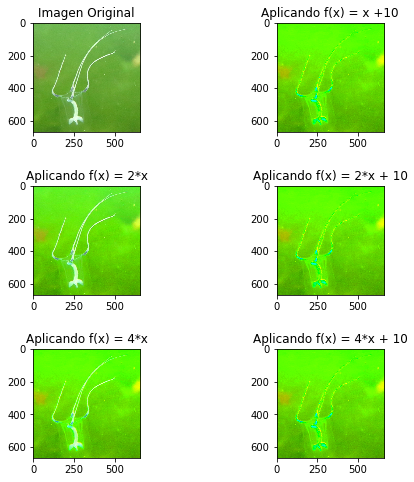

In [31]:
fig, ((a,b), (c, d), (e, f)) = plt.subplots(3, 2)
fig.subplots_adjust(hspace=.5)
fig.set_figwidth(8)
fig.set_figheight(8)


a.set_title("Imagen Original")
a.imshow(img, vmin=0, vmax=L-1)

b.set_title("Aplicando f(x) = x +10")
b.imshow(sat_1_10, vmin=0, vmax=L-1)

c.imshow(sat_2_0, vmin=0, vmax=L-1)
c.set_title("Aplicando f(x) = 2*x")

d.imshow(sat_2_10, vmin=0, vmax=L-1)
d.set_title("Aplicando f(x) = 2*x + 10")

e.imshow(sat_4_0, vmin=0, vmax=L-1)
e.set_title("Aplicando f(x) = 4*x")

f.imshow(sat_4_10, vmin=0, vmax=L-1)
f.set_title("Aplicando f(x) = 4*x + 10")

### Transformaciones no lineales

In [32]:
def tr_non_linear_transformation_saturation(img, factor_a):
    return transform_hsi(img, lambda h, s, i: (h, np.clip(pow(s, factor_a), 0, 1), i))

In [33]:
sat_2 = tr_non_linear_transformation_saturation(img, 2)
sat_3 = tr_non_linear_transformation_saturation(img, 3)
sat_02 = tr_non_linear_transformation_saturation(img, 0.2)
sat_04 = tr_non_linear_transformation_saturation(img, 0.4)
sat_06 = tr_non_linear_transformation_saturation(img, 0.6)

Text(0.5, 1.0, 'Aplicando f(x) = x^0.6')

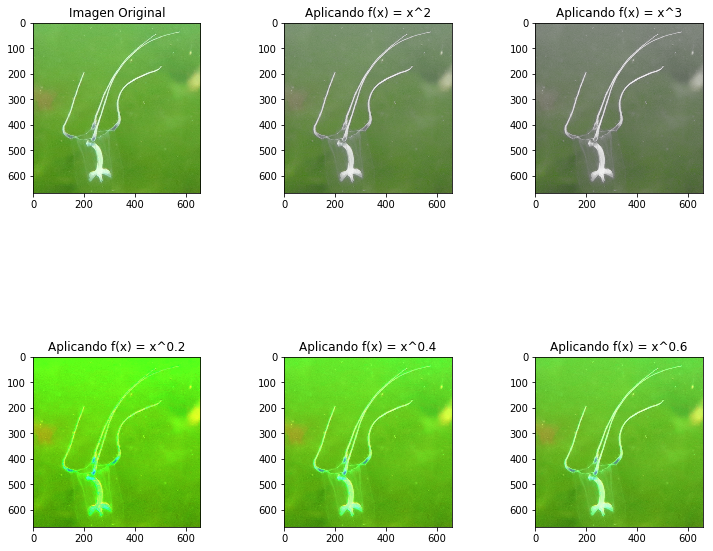

In [34]:
fig, ((a,b,c),(d,e,f)) = plt.subplots(2, 3)
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=.05)
fig.set_figwidth(12)
fig.set_figheight(12)

a.imshow(img, vmin=0, vmax=L-1)
a.set_title("Imagen Original")

b.imshow(sat_2, vmin=0, vmax=L-1)
b.set_title("Aplicando f(x) = x^2")

c.imshow(sat_3, vmin=0, vmax=L-1)
c.set_title("Aplicando f(x) = x^3")

d.imshow(sat_02, vmin=0, vmax=L-1)
d.set_title("Aplicando f(x) = x^0.2")

e.imshow(sat_04, vmin=0, vmax=L-1)
e.set_title("Aplicando f(x) = x^0.4")

f.imshow(sat_06, vmin=0, vmax=L-1)
f.set_title("Aplicando f(x) = x^0.6")

## 2. Alteración del tono (Hue)

In [35]:
def tr_increment_hue(img, inc):
    return transform_hsi(img, lambda h, s, i: ((h + inc), s, i))

Text(0.5, 1.0, 'Tono * 1')

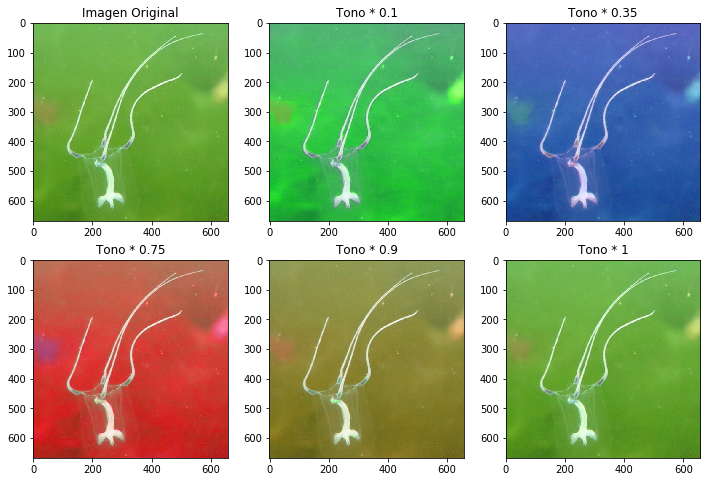

In [36]:
fig, ((a, b, c), (d, e, f)) = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(8)

a.imshow(img, vmin=0, vmax=L-1)
a.set_title("Imagen Original")

b.imshow(tr_increment_hue(img, 0.1), vmin=0, vmax=L-1)
b.set_title("Tono * 0.1")

c.imshow(tr_increment_hue(img, 0.35), vmin=0, vmax=L-1)
c.set_title("Tono * 0.35")

d.imshow(tr_increment_hue(img, 0.75), vmin=0, vmax=L-1)
d.set_title("Tono * 0.75")

e.imshow(tr_increment_hue(img, 0.9), vmin=0, vmax=L-1)
e.set_title("Tono * 0.9")

f.imshow(tr_increment_hue(img, 1), vmin=0, vmax=L-1)
f.set_title("Tono * 1")

Si vamos agregando valores al canal H, va rotando entre el rango de colores. En las primeras 3 imágenes vemos que, a medida que aumentamos c, el color se va alejando del original. Sin embargo, si seguimos aumentando, "da toda la vuelta" sobre el rango de colores, es decir, volvemos al color original.

## 3. Observaciones

## 3a. Detalles y bordes en HSI

/home/coltrane/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/coltrane/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


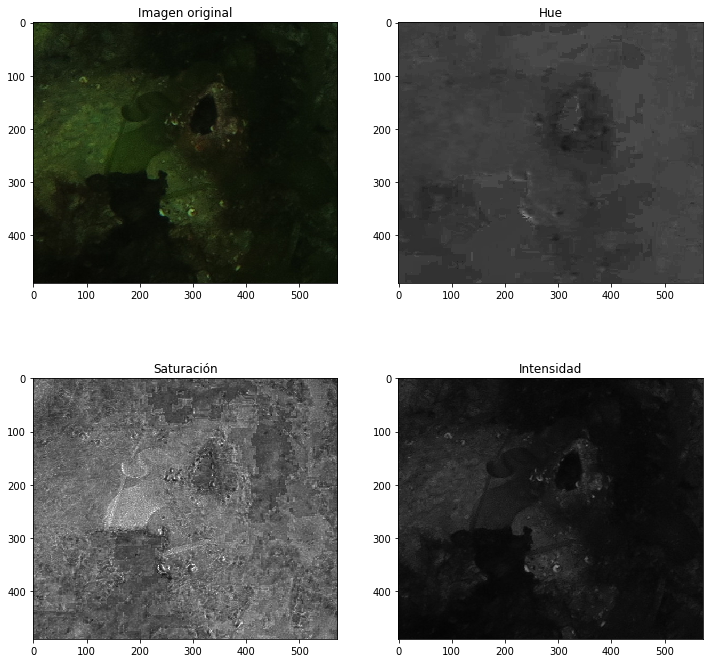

In [37]:
img2 = imread('img/1906ax.jpg')
r, g, b = img_to_norm_rgb(img2)
h, s, i = rgb_to_hsi(r, g, b)

fig, ((a, hfig), (sfig, ifig)) = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(12)

a.set_title("Imagen original")
a.imshow(img2, vmin=0, vmax=L-1)

hfig.set_title("Hue")
hfig.imshow(h, cmap=plt.cm.gray, vmin=0, vmax=1)

sfig.set_title("Saturación")
sfig.imshow(s, cmap=plt.cm.gray, vmin=0, vmax=1)

ifig.set_title("Intensidad")
ifig.imshow(i, cmap=plt.cm.gray, vmin=0, vmax=1)

a) En estas 4 figuras, se puede observar que los detalles de la imagen son más visibles en los canales de Saturación e Intensidad, mientras que el granulado de la imagen resalta en el canal de Saturación. Por otro lado, el Hue marca los cambios de tonalidades de color, con lo cual Hue no tiene mucha información para esta imagen, ya que no hay tantos colores ni cambios bruscos de color.

b) En cuanto a los bordes difuminados, se logran distinguir con más precisión en el canal de intensidad aquellos bordes que en la imagen original están difuminados.